# TP Perceptron -- Titouan Teyssier

## 1. Préparation des données

In [1]:
import csv
data_str = []
with open("house_votes_84.data", "r") as file:
    csvReader = csv.reader(file)
    for entry in csvReader:
        data_str.append(entry)

### definition de la transformation text -> num

In [2]:
def entry_str2num(entry):
    num = []
    etiquette = classe_str2num(entry[0])
    num.append(1) # pour tous les individus pour être multiplier au bias
    for val in entry[1:]:
        num.append(vote_str2num(val))
    return [etiquette, num]

def vote_str2num(s):
    return {'n': -1, 'y': 1, '?': 0}[s]

def classe_str2num(s):
    return {'republican': -1, 'democrat': 1}[s]


### definition de la transformation num -> texte

In [3]:
def vote_num2str(n):
    return {-1: 'n', 1: 'y', 0: '?'}[n]

def classe_num2str(n):
    return {-1: 'republican', 1: 'democrat'}[n]

### transformation des données textuelles en données numérique

In [4]:
data_num = [entry_str2num(entry) for entry in data_str]

### création des corpus d'apprentissage et de test

In [5]:
# on mélange les données
import numpy as np
np.random.seed(50)
np.random.shuffle(data_num)

# on découpe les données en 2 corpus: app et test
decoupage = 100
# decoupage = len(data_num)//2
corpus_test = data_num[:decoupage]
corpus_app = data_num[decoupage:]

## 2. La fonction classify

In [6]:
def sign(a):
    if a >= 0:
        return 1
    return -1

def ident(a):
    return a

def classify(individus, weight, transform=sign):
    a = sum((xi*wi for xi, wi in zip(individus, weight)))
    return transform(a)

## 3. La fonction test

In [7]:
def test(corpus, weight):
    nErr = sum((test_entry(entry, weight) for entry in corpus))
#     print(nErr)
    return nErr / len(corpus)

def test_entry(entry, weight):
    guess = classify(entry[1], weight)
    real = entry[0]
    if (guess * real) < 0:
        return 1
    return 0

## 4. La fonction train: definition d'un critère d'arret

In [8]:
# les différentes tactique pour faire une epoch
def epoch(corpus, weight, learningrate):
    for entry in corpus:
        if test_entry(entry, weight) == 1: # 1 erreur
            # maj des poids
            for i in range(len(weight)):
                weight[i] += entry[1][i] * entry[0] * learningrate


def epoch_cumul(corpus, weight, learningrate):
    cumul = [0 for w in weight]
    for entry in corpus:
        if test_entry(entry, weight) == 1: # 1 erreur
            for i in range(len(weight)):
                cumul[i] += entry[1][i] * entry[0] * learningrate
    
    for i in range(len(weight)):
        weight[i] += cumul[i]

In [9]:
# les différente tactique pour calculer le learning rate

# calcul du learning rate en fonction de l'avancement dans le nombre d'iteration
def decrease_lr(avancement):
    return 1 - avancement*0.5

# calcul du learning rate en fonction de l'avancement dans le nombre d'iteration
def lr_const(lr):
    def fun(avancement):
        return lr
    return fun

In [10]:
def train(corpus, maxIter=500, calc_lr=lr_const(1), do_epoch=epoch):
    lenw = len(corpus[0][1])
    weight = [0 for i in range(lenw)]
    best_weight = []
    lowest_err = 1
    errors = []
    errors_test = []
    err = 1
    
    for i in range(maxIter):
        do_epoch(corpus, weight, calc_lr(i/maxIter))
        err = test(corpus, weight)
        
        errors.append(err*100)
        errors_test.append(test(corpus_test, weight)*100)
        if (err < lowest_err):
            best_weight = [w for w in weight]
            lowest_err = err
        if err == 0:
            break
    affError(errors, errors_test)
    return best_weight

def affError(errors, errors_test):
    import matplotlib.pyplot as plt
    plt.plot(range(len(errors)), errors)
    plt.plot(range(len(errors_test)), errors_test)
    plt.show()

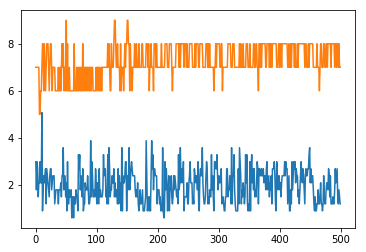

CPU times: user 1.01 s, sys: 153 ms, total: 1.16 s
Wall time: 969 ms
test corpus app: 0.60% d'erreur
test corpus test: 6.00% d'erreur
test corpus entier: 1.84% d'erreur
[19.2, -4.0, 3.2, 8.0, -21.6, -10.4, 4.8, -8.0, -2.4, 8.8, -11.2, 8.8, -2.4, 1.6, -4.8, 4.0, -4.8]


In [16]:
%time weight = train(corpus_app, 500, lr_const(0.8))

print("test corpus app: {:.2f}% d'erreur".format(test(corpus_app, weight) * 100))
print("test corpus test: {:.2f}% d'erreur".format(test(corpus_test, weight) * 100))
print("test corpus entier: {:.2f}% d'erreur".format(test(data_num, weight) * 100))

print([float("{:.2f}".format(w)) for w in weight])


### Sommes nous sùrs d'atteindre 0 erreur sur le corpus d'apprentissage ?
Non
car nous n'avons aucune garantie que le problème soit linéairement séparable.

##  Adaline

In [12]:
# les différentes tactique pour faire une epoch
def epoch_adaline(corpus, weight, learningrate):
    for entry in corpus:
        if test_entry(entry, weight) == 1: # 1 erreur
            a = classify(entry[1], weight, ident)
            # maj des poids
            for i in range(len(weight)):
                weight[i] += learningrate * entry[1][i] * (entry[0]-a)

def train_adaline(corpus, maxIter=500, calc_lr=lr_const(0.001)):
    lenw = len(corpus[0][1])
    borne = 1/lenw**0.5
    weight = [np.random.rand()*2*borne - borne for i in range(lenw)]
    best_weight = []
    lowest_err = 1
    errors = []
    errors_test = []
    err = 1
    for i in range(maxIter):
        epoch_adaline(corpus, weight, calc_lr(i/maxIter))
        err = test(corpus, weight)
        err_t = test(corpus_test, weight)
        errors.append(err*100)
        errors_test.append(err_t*100)
        if (err < lowest_err):
            best_weight = [w for w in weight]
            lowest_err = err
        if err == 0:
            break
    affError(errors, errors_test)
    return best_weight

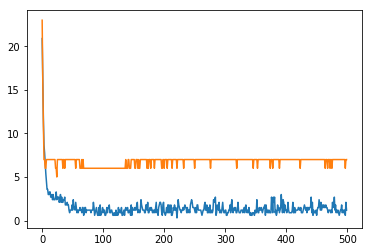

CPU times: user 1.01 s, sys: 114 ms, total: 1.12 s
Wall time: 952 ms
test corpus app: 0.30% d'erreur
test corpus test: 6.00% d'erreur
test corpus entier: 1.61% d'erreur
[0.12, -0.05, 0.04, 0.06, -0.16, -0.1, 0.03, -0.08, -0.0, 0.06, -0.07, 0.06, -0.03, 0.04, -0.0, 0.03, -0.03]


In [15]:
# weight_ada = train_adaline(corpus_app)
# weight_ada_t2 = [0.1510500567189653, -0.05900159151553557, 0.055360215335357656, 0.07034325918389381, -0.196623038187321, -0.12766209460687358, 0.037642400839676286, -0.09233007227978052, -0.000268358142666725, 0.06425635723291666, -0.07899265264944152, 0.07128998154003932, -0.03021440749812178, 0.05171664822097587, 0.005243823891725644, 0.034162255302922065, -0.03168406055189952]
# weight_ada_val = [-0.019751978426461404, 0.06234896470498003, 0.15722959975257045, -0.5694675257283899, 0.042285025099868576, 0.06299715959042836, 0.13743946696819545, 0.01587760276548989, 0.09558886312238858, -0.06569658639347606, 0.11846821021798348, -0.17751571578458303, 0.030567576424139896, 0.06753237332138436, 0.043380480310895794, -0.04813199505851452, 0.046308900272185545]
# weight_ada_val = [weight_ada_val[-1]]+ weight_ada_val[:-1]
# weight_ada = weight_ada_t2
%time weight_ada = train_adaline(corpus_app, 500)
print("test corpus app: {:.2f}% d'erreur".format(test(corpus_app, weight_ada) * 100))
print("test corpus test: {:.2f}% d'erreur".format(test(corpus_test, weight_ada) * 100))
print("test corpus entier: {:.2f}% d'erreur".format(test(data_num, weight_ada) * 100))

print([float("{:.2f}".format(w)) for w in weight_ada])